## Phase Relation

Shows spectrograms and histrograms of Mags and Group Delay.

In [10]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys
import math

import scipy.io as sio
import numpy as np
import sys

import time

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

import matplotlib.pyplot as plt
import matplotlib

print(sys.executable)
import librosa
import soundfile
import librosa.display
import seaborn as sns

from skimage.restoration import unwrap_phase

/home/knayem/anaconda3/bin/python


In [6]:
NOISES = {'SSN','CAFE','FACTORY','BABBLE'}

PLOT_SAVE_PATH = "/home/knayem/EaglesBigred2/cIRM/figures_phase/"

# CLEAN FILE PATHS
CLEAN_FILE_PATH_SSN_TRAINING = "/data/knayem/denoising_clean_wavs_SSN_10noisespercs/training_16k"
CLEAN_FILE_PATH_SSN_DEV = "/data/knayem/denoising_clean_wavs_SSN_10noisespercs/development_16k"
CLEAN_FILE_PATH_SSN_TESTING = "/data/knayem/denoising_clean_wavs_SSN_10noisespercs/testing_16k"

# MIX FILE PATHS
MIX_FILE_PATH_SSN_TESTING = "/data/knayem/denoising_mix_wavs_SSN_15000noisespercs/testing_matched"



MIX_FILE_PATH_CAFE_TESTING = '/data/knayem/denoising_mix_wavs_Cafe_15000noisespercs/testing_matched'
PATH_ONE = '/data/knayem/denoising_mix_wavs_Cafe_15000noisespercs/one'
PATH_TWO = '/data/knayem/denoising_mix_wavs_Cafe_15000noisespercs/two'

In [3]:
display_spec = 9
num_files = 0 # save number of files

PLOT_ROW = 7
PLOT_COL = 2
MAG_PLOTS = 1
ANGLE_PLOTS = 2


fs = 16e3

n_fft = 640
win_length = int(40e-3*fs) # librosa needs scalar value
overlap = int(20e-3*fs)
hop_length = win_length - overlap # librosa needs scalar value


fbin = np.linspace(0, 1, num=n_fft//2+1)*fs/2 


In [4]:
# 'power spectrogram' 1
# 'unwrap magnitude across time' 3
# 'unwrap magnitude across freq' 5

# 'wrap angle' 2
# 'unwrap angle across time' 4
# 'unwrap angle across freq' 6

# 'delta power spectrogram time' 7
# 'delta power spectrogram freq' 9
# 'delta unwrap magnitude across time' 11
# 'delta unwrap magnitude across freq' 13

# 'delta wrap angle time' 8
# 'delta wrap angle freq' 10
# 'delta unwrap angle across time'  12
# 'delta unwrap angle across freq' 14

# 'group delay wrapped' 16
# 'group delay unwrapped across time' 18
# 'group delay unwrapped across freq' 20

# 'group delay covarience accross time' 22
# 'group delay covarience accross freq' 24

# 'baseband' 26


PLOT_LIST = {
             'power spectrogram',
#              'unwrap magnitude across time',
#              'unwrap magnitude across freq', 
             'wrap angle',
#              'unwrap angle across time',
#              'unwrap angle across freq',
#              'delta power spectrogram time',
#              'delta power spectrogram freq',
#              'delta unwrap magnitude across time',
#              'delta unwrap magnitude across freq',
#              'delta wrap angle time',
#              'delta wrap angle freq',
#              'delta unwrap angle across time',
#              'delta unwrap angle across freq',
#              'group delay wrapped',
             'group delay unwrapped',
#              'group delay covarience accross time',
#              'group delay covarience accross freq',
#              'baseband',
            }


In [5]:
def unwrap2d(A, discont=np.pi, axis=-1):
    
    axis = len(A.shape)-1 if axis<0 else axis
    
    xindx = -1 if axis == 0 else 0
    yindx = -1 if axis == 1 else 0
    
    B = np.zeros(A.shape)
    
    for i, row in enumerate(A):
        for j, col in enumerate(row):
            
            
            if i == 0 and col>=0 and col<=2*np.pi:
                B[i,j] = col
 
            else:
                a = A[i+xindx,j+yindx] if i==0 else B[i+xindx,j+yindx]
                sign=math.copysign(1, a-col)
                b = col
                c = 0
                while b<0 or b>2*np.pi or abs(a-b)>2*np.pi:
#                 while b<0 or b>2*np.pi:
                    sign = math.copysign(1, a-b)
                    b += (2*np.pi)*sign      
                    c+=1
                    
                    if c>10:
                        print("i=",i,", j=",j, "->b=",b)
                        break
    
                B[i,j] = b

    return B


In [7]:
P = np.array([
    [0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00, 0.0000000e+00],
    [-3.1415925e+00 , 3.1250732e+00,  2.9109616e+00 ,-3.0852456e+00 ,-2.9841640e+00],
    [-3.1415925e+00 , 1.2131550e-01, -1.2484106e+00,  2.7467303e+00 ,1.2115452e+00],
    [1.1191743e-16, -6.5125799e-01,  2.7417612e+00, -2.6222405e-01,  -1.2107065e+00],
    [3.1415925e+00,  2.8795302e+00 , 9.0207589e-01, -2.7468257e+00, 1.4193216e-01]]
)
P1 = np.array([
    [ 0.      ,    0.     ,     0.     ,     0.   ,       0.        ],
 [ 3.052169  ,  3.0590367 , -3.0453265 , -2.5315228 ,  3.0761716 ],
 [-1.7740763 , -0.37031716, -0.46965742,  2.1574366 , -0.5789001 ],
 [ 2.0131686 ,  1.2242619 , -0.11566371, -2.9567769 ,  1.8333427 ],
 [-2.590712  ,  2.0239015 , -1.7847241 ,  0.21576202,  2.110056  ]]
)
P2 = np.array([
    [ 0.   ,       0.     ,     0.    ,      0.      ,    0.        ],
 [ 3.07797146,  2.98140192 , 3.2876392 ,  3.09636879,  2.84780526],
 [ 3.10858774,  4.49794478, -6.70092535 , 3.83206374,  3.235241  ],
 [ 6.07674632 ,-6.44974423,  3.36424572 , 1.8613621 ,  0.43922842],
 [ 3.65950042 , 1.91907942,  2.39994621 , 4.38870711 , 5.67454702]]
)
P3 = np.array([
    [ 0.      ,    0.      ,    0.       ,   0.      ,    0.        ],
 [ 3.06151509 , 3.00323057 , 3.30338556  ,3.21017534,  3.14184362],
 [ 3.10502243 , 4.08983308 ,-7.44926721  ,0.09411523 ,-7.27739817],
 [ 4.00542242 , 0.11945556 , 2.1685729   ,5.31021572 , 2.71552229],
 [ 2.02302337 , 2.05695844 , 5.68479377 , 0.98324776,  5.17937714]]
)
unwrap2d(P1, axis=0)

array([[0.        , 0.        , 0.        , 0.        , 0.        ],
       [3.052169  , 3.0590367 , 3.23785881, 3.75166251, 3.0761716 ],
       [4.50910901, 5.91286815, 5.81352789, 2.1574366 , 5.70428521],
       [2.0131686 , 1.2242619 , 6.1675216 , 3.32640841, 1.8333427 ],
       [3.69247331, 2.0239015 , 4.49846121, 0.21576202, 2.110056  ]])

In [ ]:
MAG_PLOTS = 1
ANGLE_PLOTS = 2

angle_selected = []
unwrap_angle_selected = []

matplotlib.rc('xtick', labelsize=15) 
matplotlib.rc('ytick', labelsize=15) 
label_size = 18

for root, dirs, files in os.walk(PATH_TWO):
    
    num_files = len(files)
#     indx = range(0,num_files,num_files//display_spec)
    indx = range(0,len(files))
    
    for enum, filename in enumerate(files):

        FILE_NAME = root+'/'+filename
        print(filename)
        y, sr = librosa.load(FILE_NAME, fs)
        
        s_stft = librosa.stft(y,n_fft,hop_length,win_length)
        mag, phase = librosa.magphase(s_stft)
        angle = np.angle(phase)
        
        angle_cov = np.cov(angle)
        angle_diff = np.zeros(phase.shape)
        phase_diff = np.zeros(phase.shape)
        
        for r in range(angle_diff.shape[0]):
            phase_diff[r] = abs(phase[r] - phase[(r+1)%phase_diff.shape[0]]) # real value
            angle_diff[r] = abs(angle[r] - angle[(r+1)%angle_diff.shape[0]]) # real value
            
        if enum == 0:
            angle_cov_all = np.zeros( (angle.shape[0],angle.shape[0]) )
            
        angle_cov_all += np.cov(angle)
#         print(np.cov(angle).shape, angle.shape, angle_cov_all.shape)
                
        if enum in indx:
            
            angle_selected.append(angle)
            
            plot_serial = 1
            MAG_PLOTS = 1
            ANGLE_PLOTS = 2

#             plt.figure(figsize=(24//2, 4.5*len(PLOT_LIST)))
            plt.figure(figsize=(16, 32))
            D = librosa.amplitude_to_db(mag, ref=np.max)
            
            ######################################################################
            ##################     Log t-f power spectrogram   ###################
            ######################################################################
            if 'power spectrogram' in PLOT_LIST:
#                 plt.subplot(1, len(PLOT_LIST), plot_serial)
                ax = plt.subplot(PLOT_ROW, PLOT_COL, MAG_PLOTS)
                librosa.display.specshow(D, y_axis='hz', x_axis='time', sr=fs)
                plt.colorbar(format='%+2.0f dB')
                plt.title(str(enum)+'->Log t-f power spectrogram,\n'+filename)
                ax.set_xlabel("Time", fontsize=label_size)
                ax.set_ylabel("Hz", fontsize=label_size)
                plt.subplots_adjust(hspace=0.5)
                plot_serial+=1
                MAG_PLOTS += 2
                
#                 f_name = PLOT_SAVE_PATH+filename+'_power spectrogram'+'.png'
#                 plt.savefig(f_name,bbox_inches='tight')
                
                
            ######################################################################
            ###########     Log t-f unwrap magnitude across time   ###############
            ######################################################################
            if 'unwrap magnitude across time' in PLOT_LIST:
#                 plt.subplot(1, len(PLOT_LIST), plot_serial)
                plt.subplot(PLOT_ROW, PLOT_COL, MAG_PLOTS)
                librosa.display.specshow(np.unwrap(D), y_axis='log', x_axis='time', sr=fs)
                plt.colorbar(format='%+2.0f dB')
                plt.title(str(enum)+'->Log t-f unwrap magnitude across t,\n'+filename)
                plot_serial+=1
                MAG_PLOTS += 2
                
#                 f_name = PLOT_SAVE_PATH+filename+'_unwrap magnitude across time'+'.png'
#                 plt.savefig(f_name,bbox_inches='tight')
                
            
            ######################################################################
            ###########     Log t-f unwrap magnitude across freq   ###############
            ######################################################################
            if 'unwrap magnitude across freq' in PLOT_LIST:
#                 plt.subplot(1, len(PLOT_LIST), plot_serial)
                plt.subplot(PLOT_ROW, PLOT_COL, MAG_PLOTS)
                librosa.display.specshow(np.unwrap(D, axis=0), y_axis='log', x_axis='time', sr=fs)
                plt.colorbar(format='%+2.0f dB')
                plt.title(str(enum)+'->Log t-f unwrap magnitude across freq,\n'+filename)
                plot_serial+=1
                MAG_PLOTS += 2
                
#                 f_name = PLOT_SAVE_PATH+filename+'_unwrap magnitude across freq'+'.png'
#                 plt.savefig(f_name,bbox_inches='tight')
            
            
            ######################################################################
            #################     Log t-f wrap angle(radiens)    #################
            ######################################################################
            if 'wrap angle' in PLOT_LIST:
#                 plt.subplot(1, len(PLOT_LIST), plot_serial)
                ax = plt.subplot(PLOT_ROW, PLOT_COL, ANGLE_PLOTS)
                librosa.display.specshow(angle, y_axis='hz', x_axis='time', sr=fs)
                plt.colorbar(format='%+2.2f')
                ax.set_xlabel("Time", fontsize=label_size)
                ax.set_ylabel("Hz", fontsize=label_size)
#                 plt.title(str(enum)+'->Log t-f wrap angle(radiens),\n'+filename)
                plt.subplots_adjust(hspace=0.5)
                plot_serial+=1
                ANGLE_PLOTS += 2
                
#                 f_name = PLOT_SAVE_PATH+filename+'_wrap angle'+'.png'
#                 plt.savefig(f_name,bbox_inches='tight')
                
                
            ######################################################################
            #############     Log t-f unwrap angle across time   #################
            ######################################################################
            if 'unwrap angle across time' in PLOT_LIST:
#                 plt.subplot(1, len(PLOT_LIST), plot_serial)
                plt.subplot(PLOT_ROW, PLOT_COL, ANGLE_PLOTS)
    
                librosa.display.specshow( np.unwrap(angle), y_axis='log', x_axis='time', sr=fs)
                plt.colorbar(format='%+2.2f')
                plt.title(str(enum)+'->Log t-f unwrap angle(radiens) across time,\n'+filename)
                plot_serial+=1
                ANGLE_PLOTS += 2
            
            ######################################################################
            #############     Log t-f unwrap angle across freq   #################
            ######################################################################
            if 'unwrap angle across freq' in PLOT_LIST:
#                 plt.subplot(1, len(PLOT_LIST), plot_serial)
                plt.subplot(PLOT_ROW, PLOT_COL, ANGLE_PLOTS)
                librosa.display.specshow( np.unwrap(angle,axis=0), y_axis='log', x_axis='time', sr=fs)
                plt.colorbar(format='%+2.2f')
                plt.title(str(enum)+'->Log t-f unwrap angle(radiens) across freq,\n'+filename)
                plot_serial+=1
                ANGLE_PLOTS += 2
            
            ######################################################################
            #################     delta power spectrogram time   #################
            ######################################################################
            if 'delta power spectrogram time' in PLOT_LIST:
#                 plt.subplot(1, len(PLOT_LIST), plot_serial)
                plt.subplot(PLOT_ROW, PLOT_COL, MAG_PLOTS)
                
                D_s = np.roll(D, -1, axis=1) # time
                librosa.display.specshow(abs(D-D_s), y_axis='log', x_axis='time', sr=fs)
                plt.colorbar(format='%+2.0f dB')
                plt.title(str(enum)+'->delta power spectrogram time,\n'+filename)
                plot_serial+=1
                MAG_PLOTS += 2
    
            ######################################################################
            #################     delta power spectrogram freq   #################
            ######################################################################
            if 'delta power spectrogram freq' in PLOT_LIST:
#                 plt.subplot(1, len(PLOT_LIST), plot_serial)
                plt.subplot(PLOT_ROW, PLOT_COL, MAG_PLOTS)
                
                D_s = np.roll(D, 1, axis=0) # freq
                librosa.display.specshow(abs(D-D_s), y_axis='log', x_axis='time', sr=fs)
                plt.colorbar(format='%+2.0f dB')
                plt.title(str(enum)+'->delta power spectrogram freq,\n'+filename)
                plot_serial+=1
                MAG_PLOTS += 2
            
            ######################################################################
            ############     delta unwrap magnitude across time   ###########
            ######################################################################
            if 'delta unwrap magnitude across time' in PLOT_LIST:
#                 plt.subplot(1, len(PLOT_LIST), plot_serial)
                plt.subplot(PLOT_ROW, PLOT_COL, MAG_PLOTS)
                
                D_s = np.roll(D, -1, axis=1) # time
                librosa.display.specshow(abs(D-D_s), y_axis='log', x_axis='time', sr=fs)
                plt.colorbar(format='%+2.0f dB')
                plt.title(str(enum)+'->delta unwrap magnitude across time,\n'+filename)
                plot_serial+=1
                MAG_PLOTS += 2
                
            ######################################################################
            ############     delta unwrap magnitude across freq   ###########
            ######################################################################
            if 'delta unwrap magnitude across freq' in PLOT_LIST:
#                 plt.subplot(1, len(PLOT_LIST), plot_serial)
                plt.subplot(PLOT_ROW, PLOT_COL, MAG_PLOTS)
                
                D_s = np.roll(D, 1, axis=0) # freq
                librosa.display.specshow(abs(D-D_s), y_axis='log', x_axis='time', sr=fs)
                plt.colorbar(format='%+2.0f dB')
                plt.title(str(enum)+'->delta unwrap magnitude across freq,\n'+filename)
                plot_serial+=1
                MAG_PLOTS += 2

            ######################################################################
            #################     delta wrap angle time   #################
            ######################################################################
            if 'delta wrap angle time' in PLOT_LIST:
#                 plt.subplot(1, len(PLOT_LIST), plot_serial)
                plt.subplot(PLOT_ROW, PLOT_COL, ANGLE_PLOTS)
    
                angle_s = np.roll(angle, -1, axis=1) # time
                librosa.display.specshow(abs(angle-angle_s), y_axis='hz', x_axis='time', sr=fs)
                plt.colorbar(format='%+2.0f dB')
#                 plt.title(str(enum)+'->delta wrap angle time,\n'+filename)
                plot_serial+=1
                ANGLE_PLOTS += 2
    
            ######################################################################
            #################     delta wrap angle freq   #################
            ######################################################################
            if 'delta wrap angle freq' in PLOT_LIST:
#                 plt.subplot(1, len(PLOT_LIST), plot_serial)
                plt.subplot(PLOT_ROW, PLOT_COL, ANGLE_PLOTS)
                
                angle_s = np.roll(angle, 1, axis=0) # freq
                librosa.display.specshow(abs(angle-angle_s), y_axis='log', x_axis='time', sr=fs)
                plt.colorbar(format='%+2.0f dB')
                plt.title(str(enum)+'->delta wrap angle freq,\n'+filename)
                plot_serial+=1
                ANGLE_PLOTS += 2
            
            ######################################################################
            ############     delta unwrap angle across time   ###########
            ######################################################################
            if 'delta unwrap angle across time' in PLOT_LIST:
#                 plt.subplot(1, len(PLOT_LIST), plot_serial)
                plt.subplot(PLOT_ROW, PLOT_COL, ANGLE_PLOTS)
                
                angle_s = np.roll(angle, -1, axis=1) # time
                librosa.display.specshow(abs(angle-angle_s), y_axis='log', x_axis='time', sr=fs)
                plt.colorbar(format='%+2.0f dB')
                plt.title(str(enum)+'->delta unwrap angle across time,\n'+filename)
                plot_serial+=1
                ANGLE_PLOTS += 2
                
            ######################################################################
            ############     delta unwrap angle across freq   ###########
            ######################################################################
            if 'delta unwrap angle across freq' in PLOT_LIST:
#                 plt.subplot(1, len(PLOT_LIST), plot_serial)
                plt.subplot(PLOT_ROW, PLOT_COL, ANGLE_PLOTS)
    
                angle_s = np.roll(angle, 1, axis=0) # freq
                librosa.display.specshow(abs(angle-angle_s), y_axis='log', x_axis='time', sr=fs)
                plt.colorbar(format='%+2.0f dB')
                plt.title(str(enum)+'->delta unwrap angle across freq,\n'+filename)
                plot_serial+=1
                ANGLE_PLOTS += 2
            
            ######################################################################
            #################     group delay wrapped   #################
            ######################################################################
            if 'group delay wrapped' in PLOT_LIST:
#                 plt.subplot(1, len(PLOT_LIST), plot_serial)
                plt.subplot(PLOT_ROW, PLOT_COL, ANGLE_PLOTS)
                
                angle_s = np.roll(angle, 1, axis=0) # roll across freq
                gd = np.angle(np.exp(1j*(angle-angle_s))) # paper implementation
#                 gd = -abs(angle-angle_s)/(fbin[1]-fbin[0])
                
                librosa.display.specshow(gd, y_axis='hz', x_axis='time', sr=fs)
                plt.colorbar(format='%+2.3f dB')
                plt.title(str(enum)+'->group delay wrapped,\n'+filename)
                plt.subplots_adjust(hspace=0.5)
                plot_serial+=1
                ANGLE_PLOTS += 2
            
            ######################################################################
            #################     group delay unwrapped   #################
            ######################################################################
            if 'group delay unwrapped' in PLOT_LIST:
#                 plt.subplot(1, len(PLOT_LIST), plot_serial)
                ax = plt.subplot(PLOT_ROW, PLOT_COL, ANGLE_PLOTS)
                
                
#                 unwrap_angle = unwrap2d(angle, axis=0)
                unwrap_angle2 = np.unwrap(angle, axis=0) # freq
    
#                 unwrap_angle_selected.append(unwrap_angle)
        
#                 xs,ys=np.where(unwrap_angle<0)
#                 print('-ve:',len(xs))
#                 for e,(x,y) in enumerate(zip(xs,ys)):
#                     tr = x-2 if x-2>=0 else 0
#                     br = x+3 if x+3<unwrap_angle.shape[0] else unwrap_angle.shape[0]
#                     lc = y-2 if y-2>=0 else 0
#                     rc = y+3 if y+3<unwrap_angle.shape[1] else unwrap_angle.shape[1]
#                     print('(',x,',',y,")-range[",tr,":",br,"][",lc,':',rc,']\nunwrap_angle\n', unwrap_angle[tr:br,lc:rc] )
#                     print('Angle\n', angle[tr:br,lc:rc] )
                    
#                     if e == 2:
#                         break
        
#                 unwrap_angle_s = np.roll(unwrap_angle, 1, axis=0) # roll across freq
                unwrap_angle_s2 = np.roll(unwrap_angle2, 1, axis=0) # roll across freq
            
                unwrap_gd2 = np.angle(np.exp(1j*(unwrap_angle2 - unwrap_angle_s2))) # paper implementation
#                 unwrap_gd = -abs(unwrap_angle-unwrap_angle_s)/(fbin[1]-fbin[0])
#                 unwrap_gd2 = -abs(unwrap_angle2-unwrap_angle_s2)/(fbin[1]-fbin[0])

                # Matlab unwrap()
                librosa.display.specshow(unwrap_gd2, y_axis='hz', x_axis='time', sr=fs)
                plt.colorbar(format='%+2.3f dB')
                ax.set_xlabel("Time", fontsize=label_size)
                ax.set_ylabel("Hz", fontsize=label_size)
#                 plt.title(str(enum)+'->group delay unwrapped MATLAB,\n'+filename)
                plt.subplots_adjust(hspace=0.5)
                plot_serial+=1
                ANGLE_PLOTS += 2
        
#                 plt.subplot(PLOT_ROW, PLOT_COL, ANGLE_PLOTS)
#                 librosa.display.specshow(unwrap_gd, y_axis='hz', x_axis='time', sr=fs)
#                 plt.colorbar(format='%+2.3f dB')
#                 plt.title(str(enum)+'->group delay unwrapped,\n'+filename)
#                 plt.subplots_adjust(hspace=0.5)
#                 plot_serial+=1
#                 ANGLE_PLOTS += 2
                
            ######################################################################
            ############   group delay covarience accross time   #################
            ######################################################################
            if 'group delay covarience accross time' in PLOT_LIST:
#                 plt.subplot(1, len(PLOT_LIST), plot_serial)
                plt.subplot(PLOT_ROW, PLOT_COL, ANGLE_PLOTS)
                
                for i, t in enumerate(gd.T):
                    cov_t = np.dot(t.T - t.mean(), gd - gd.mean(axis=0)) / (t.shape[0]-1)
                    if i == 0:
                        cov_gd_t = [cov_t] 
                    else:
                        cov_gd_t = np.concatenate((cov_gd_t,[cov_t]),axis=0)
                        
                t_max, t_min = cov_gd_t.max(), cov_gd_t.min()
                gd_t = (cov_gd_t - t_min)/(t_max - t_min)

                ax = sns.heatmap(
                    gd_t, fmt='%+2.2f',
                    cmap=sns.diverging_palette(20, 220, n=200),
                    square=True,
                )
                plt.title(str(enum)+'->group delay covarience accross time,\n'+filename)
                plt.subplots_adjust(hspace=0.5)
                plot_serial+=1
                ANGLE_PLOTS += 2
                
            ######################################################################
            ############   group delay covarience accross freq   #################
            ######################################################################
            if 'group delay covarience accross freq' in PLOT_LIST:
#                 plt.subplot(1, len(PLOT_LIST), plot_serial)
                plt.subplot(PLOT_ROW, PLOT_COL, ANGLE_PLOTS)
                
                for i, t in enumerate(gd):
                    cov_f = np.dot( (t.T - t.mean()).T, gd.T - gd.T.mean(axis=0)) / (t.shape[0]-1)
                    
                    if i == 0:
                        cov_gd_f = [cov_f] 
                    else:
                        cov_gd_f = np.concatenate((cov_gd_f,[cov_f]),axis=0)
                    
                f_max, f_min = cov_gd_f.max(), cov_gd_f.min()
                gd_f = (cov_gd_f - f_min)/(f_max - f_min)
                
                ax = sns.heatmap(
                    gd_f, fmt='%+2.2f',
                    cmap=sns.diverging_palette(20, 220, n=200),
                    square=True,
                )
                plt.title(str(enum)+'->group delay covarience accross freq,\n'+filename)
                plt.subplots_adjust(hspace=0.5)
                plot_serial+=1
                ANGLE_PLOTS += 2
            
            ######################################################################
            ###########################     baseband   ###########################
            ######################################################################
            if 'baseband' in PLOT_LIST:
#                 plt.subplot(1, len(PLOT_LIST), plot_serial)
                plt.subplot(PLOT_ROW, PLOT_COL, ANGLE_PLOTS)
                
                for l, Y in enumerate(s_stft.T):
                    b = Y*np.exp(-1j*fs*l*0.5)
                    if l ==0 :
                        Y_B = [b]
                    else:
                        Y_B = np.concatenate((Y_B,[b]),axis=0)
                        
                
                mag_B, phase_B = librosa.magphase(Y_B.T)
                angle_B = np.angle(phase_B)
        
                librosa.display.specshow(angle_B, y_axis='log', x_axis='time', sr=fs)
                plt.colorbar(format='%+2.0f dB')
                plt.title(str(enum)+'->baseband,\n'+filename)
                plot_serial+=1
                ANGLE_PLOTS += 2
        
            
            # save figures
            f_name = PLOT_SAVE_PATH+filename+'_all'+'.png'
            plt.savefig(f_name,bbox_inches='tight')
            
            

S_62_02_16k.wav


KeyboardInterrupt: 

### Freq histogram

In [75]:
display_freq = 100

num_freq = angle_selected[0].shape[0]

indx = np.linspace(0,num_freq,display_freq, endpoint=False, dtype='int')

indx2 = [n for n in range(0,100)]
indx2.extend(indx[indx>100])
indx = indx2
len(indx)

168

In [76]:
# TYPE = 'UNWRAP'
TYPE = 'WRAP'

bin_size = 10


from scipy.stats import norm
from matplotlib.ticker import FormatStrFormatter


plt.figure(figsize=(20, 5*len(indx)))


if TYPE == 'WRAP':
    BINS = np.linspace(-np.pi,np.pi,bin_size)
    selected = angle_selected
else:
    BINS = np.linspace(0,2*np.pi,bin_size)
    selected = unwrap_angle_selected
    
    
for p, f in enumerate(indx):
    freq_channel = []
    for e, angle in enumerate(selected):
        # concate
        freq_channel.extend(angle[f])
    
    ax = plt.subplot(len(indx), 1, p+1)
    kwargs = dict(hist_kws={'alpha':.6, 'density':False, 'rwidth':0.8}, kde_kws={'linewidth':.1} )
#     ax = sns.distplot(freq_channel, kde=True,  axlabel='angles', label='count')
#     ax = sns.distplot(freq_channel, kde=True, bins=bin_size, axlabel='phase', label='frequency', **kwargs)
#   
    counts,bins,patches = plt.hist(freq_channel, bins=BINS, density=False, facecolor='g', alpha=0.75, rwidth=0.8)
    
    plt.xticks(rotation=90)
    ax.set_xticks(bins)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%0.1f'))
    
    bin_centers = 0.5 * np.diff(bins) + bins[:-1]
    for i, (count, x) in enumerate(zip(counts, bin_centers)):
        # Label the raw counts
        height = patches[i].get_height()
        ax.annotate(str(count), xy=(x, 0), xycoords=('data', 'axes fraction'),
            xytext=(0, height//len(indx) +7), textcoords='offset points', va='top', ha='center')


    # Give ourselves some more room at the bottom of the plot
    plt.subplots_adjust(hspace=0.5)
    plt.title('Group delay histrogram of freq '+str(f)+'\n' )

#     if p==0:
#         break
    
# save figure
f_name = PLOT_SAVE_PATH+'histogram_all_'+TYPE+str(bin_size)+'.png'
plt.savefig(f_name,bbox_inches='tight')

In [62]:
ax[1]

TypeError: 'AxesSubplot' object does not support indexing

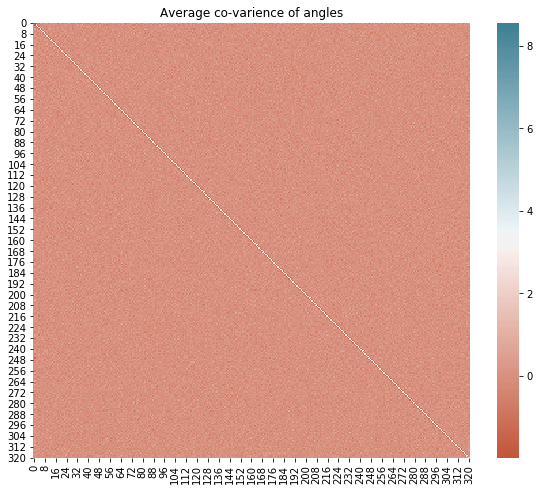

In [10]:
avg_phase_diff = angle_cov_all/num_files


plt.figure(figsize=(10,8))
ax = sns.heatmap(
    np.cov(angle), fmt='%+2.4f',
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

plt.title("Average co-varience of angles")
plt.show()